## 5. Regression Models

In [1]:
# Enable R cell for later use
%load_ext rpy2.ipython

In [2]:
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from feature_engineering import feature_engineer, drop_cols
from mlxtend.regressor import StackingRegressor
from model_comparer import ModelComparer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

%matplotlib inline

# Read data from the data folder
file_directory = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '')) + '\\'
sample = True
        
max_window = 3
sample_size = 100

try:
    df_combined = pd.read_csv(file_directory + 'data/horse_race_combined.csv', low_memory=False, index_col=0)
    df_combined['run_date'] = df_combined['run_date'].apply(lambda x: pd.Timestamp(x))
    df_combined = df_combined.sort_values(['horse_id', 'run_date'])
    
    if sample:
        df_combined = df_combined.iloc[:sample_size]
    
    df_combined.set_index(['horse_id', 'run_date'], inplace=True)
    
    first_occur_df = pd.read_csv(file_directory + 'data/first_occurence_race.csv', low_memory=False, index_col=0)
    first_occur_df['run_date'] = first_occur_df['run_date'].apply(pd.Timestamp)
    first_occur_df = first_occur_df.sort_values(['horse_id', 'run_date'])
    drop_cols(first_occur_df)
    
    df_combined = df_combined[~df_combined.index.isin(first_occur_df.sort_values(['horse_id', 'run_date']).set_index(['horse_id', 'run_date']).index)]
except FileNotFoundError:
    horse_race_df = pd.read_csv(file_directory + 'data/horse_race.csv', low_memory=False, index_col=0)
    horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)
    horse_race_df['run_date'] = horse_race_df['run_date'].apply(pd.Timestamp)
    horse_race_df = horse_race_df.sort_values(['horse_id', 'run_date'])
    drop_cols(horse_race_df)
    
    df_combined = horse_race_df.set_index(['horse_id', 'run_date'])
    df_combined['run_time_diff'] = df_combined['run_time_1000'].diff()
    df_combined['last_run_time'] = df_combined['run_time_1000'] - df_combined['run_time_diff']
    df_combined['run_time_quo'] = df_combined['run_time_1000'] / df_combined['last_run_time']
    df_combined['run_time_mean'] = df_combined['last_run_time']

    df_reset = df_combined['run_time_mean'].reset_index()
    horse_id_lst = list(df_reset['horse_id'])
    run_time_mean_lst = list(df_reset['run_time_mean'])
    new_run_time_mean_lst = []
    new_run_time_median_lst = []
    curr_index = horse_id_lst[0]
    curr_count = 0
    curr_sum = 0
    curr_stored = []
    for index, value in zip(horse_id_lst, run_time_mean_lst):
        if index != curr_index:
            curr_count = 1
            curr_sum = value
            curr_index = index
            curr_stored = [value]
        else:
            curr_count += 1
            curr_sum += value
            curr_stored.append(value)
        new_run_time_mean_lst.append(curr_sum / (curr_count * 1.0))
        new_run_time_median_lst.append(np.median(curr_stored))
    df_combined['run_time_mean'] = pd.Series(new_run_time_mean_lst, index=df_combined.index)
    df_combined['run_time_median'] = pd.Series(new_run_time_median_lst, index=df_combined.index)

    for window in range(2, max_window + 1):
        ma = df_combined.groupby(level=0)['run_time_1000'].rolling(window).mean().groupby(level=0).shift(1)
        ma = ma.reset_index(level=1)['run_time_1000'].reset_index()
        ewma = df_combined.groupby(level=0)['run_time_1000'].apply(lambda series: series.ewm(ignore_na=True, 
                                                                                             min_periods=window, 
                                                                                             adjust=True,
                                                                                             com=0.030927835051546).mean())
        ewma = ewma.groupby(level=0).shift(1)
        df_combined['run_time_ma_window_%s' % str(window)] = ma.set_index(['horse_id', 'run_date'])['run_time_1000']
        df_combined['run_time_ewma_window_%s' % str(window)] = ewma
    df_combined.reset_index().to_csv('data/horse_race_combined.csv', encoding='utf-8')

C:\Users\terry\Anaconda3\lib\site-packages\cmocean\tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
dependent = ['run_time_1000',
             'run_time_diff', 'run_time_quo', 
             'run_time_mean', 'run_time_median'] + \
            ['run_time_ma_window_%s' % str(idx) for idx in range(2, max_window + 1)] + \
            ['run_time_ewma_window_%s' % str(idx) for idx in range(2, max_window + 1)]
df_combined_y = df_combined[dependent].copy()
df_combined_x = df_combined[list(filter(lambda x: x not in dependent, df_combined.columns))].copy()
df_y_original_dict = {}
df_y_original_dict['run_time_diff'] = df_combined_x['last_run_time']
df_y_original_dict['run_time_quo'] = df_combined_x['last_run_time']
for col_name in dependent[3:]:
    df_combined_y[col_name + '_diff'] = df_combined_y['run_time_1000'] - df_combined_y[col_name]
    df_combined_y[col_name + '_quo'] = df_combined_y['run_time_1000'] / df_combined_y[col_name]
    df_y_original_dict[col_name + '_diff'] = df_combined_y[col_name]
    df_y_original_dict[col_name + '_quo'] = df_combined_y[col_name]
    df_combined_y.drop(col_name, axis=1, inplace=True)
df_combined_y[list(filter(lambda x: 'diff' in x or 'quo' in x, df_combined_y.columns))].T

horse_id                             1986102130          1989107128  \
run_date                    2000-01-29 15:40:00 2000-02-05 13:45:00   
run_time_diff                          1.642857           -1.146258   
run_time_quo                           1.027381            0.983224   
run_time_mean_diff                          NaN            2.547192   
run_time_mean_quo                           NaN            1.039409   
run_time_median_diff                        NaN            2.547192   
run_time_median_quo                         NaN            1.039409   
run_time_ma_window_2_diff                   NaN                 NaN   
run_time_ma_window_2_quo                    NaN                 NaN   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN                 NaN   
run_time_ewma_window_2_quo                  NaN                 NaN   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                                                             \
run_date                    2000-03-11 15:10:00 2000-04-15 15:30:00   
run_time_diff                          0.510490            2.697936   
run_time_quo                           1.007599            1.039856   
run_time_mean_diff                     2.208618            4.354399   
run_time_mean_quo                      1.033728            1.065940   
run_time_median_diff                   0.510490            2.953181   
run_time_median_quo                    1.007599            1.043792   
run_time_ma_window_2_diff             -0.062639            2.953181   
run_time_ma_window_2_quo               0.999076            1.043792   
run_time_ma_window_3_diff                   NaN            2.656177   
run_time_ma_window_3_quo                    NaN            1.039215   
run_time_ewma_window_2_diff            0.477103            2.712237   
run_time_ewma_window_2_quo             1.007098            1.040076   
run_time_ewma_window_3_diff                 NaN            2.712237   
run_time_ewma_window_3_quo                  NaN            1.040076   

horse_id                             1990104469                      \
run_date                    2000-03-18 11:45:00 2000-04-15 15:30:00   
run_time_diff                          1.279356            1.830030   
run_time_quo                           1.019112            1.026826   
run_time_mean_diff                    -0.446069            1.532651   
run_time_mean_quo                      0.993504            1.022369   
run_time_median_diff                  -0.446069            1.830030   
run_time_median_quo                    0.993504            1.026826   
run_time_ma_window_2_diff                   NaN            2.469709   
run_time_ma_window_2_quo                    NaN            1.036545   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN            1.867293   
run_time_ewma_window_2_quo                  NaN            1.027387   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                             1991100019                      \
run_date                    2000-02-12 15:45:00 2000-03-19 15:00:00   
run_time_diff                          0.214286           -1.160714   
run_time_quo                           1.003567            0.980746   
run_time_mean_diff                    -4.396341           -4.091609   
run_time_mean_quo                      0.932032            0.935276   
run_time_median_diff                  -4.396341           -1.160714   
run_time_median_quo                    0.932032            0.980746   
run_time_ma_window_2_

## 5.1 OLS Trial Run

In [4]:
# Model testing for run time residual
x = feature_engineer(df_combined_x.reset_index())
x = x.drop('last_run_time', axis=1)
y = df_combined_y.loc[df_combined_y.index.isin(x.index), 'run_time_diff']

# OLS
reg = LinearRegression(fit_intercept=False)
scores_reg = cross_val_score(reg, x, y, scoring='neg_mean_squared_error')
print("RMSE for OLS: %0.5f" % np.sqrt(-scores_reg.mean()))

RMSE for OLS: 12.71805


## 5.2 Baseline Regression Models and Stacking

In [89]:
try:
    report_directory = file_directory + 'predictive/report/'
    
    # Initiate class object
    mc = ModelComparer(df_combined_x, df_combined_y, df_y_original_dict, random_state=37)
    r_square_score = make_scorer(ModelComparer.get_r_squared, greater_is_better=True)
    rmse_score = make_scorer(ModelComparer.get_rmse, greater_is_better=False)
    
    rmse_report = pd.read_csv(report_directory + 'rmse_report_baseline.csv', index_col=0)
    rsquare_report = pd.read_csv(report_directory + 'rsquare_report_baseline.csv', index_col=0)
except FileNotFoundError:
    # Add base model
    mc.add_model(LinearRegression, model_name='OLS - Base Model', fit_intercept=False)
    mc.add_model(XGBRegressor, 'XGB - Base Model (0.1LR)', learning_rate=0.1)
    mc.add_model(DecisionTreeRegressor, 'DT - Base Model (6MD)', max_depth=6)
    mc.add_model(RandomForestRegressor, 'RF - Base Model (6MD)', max_depth=6)
    mc.add_model(GradientBoostingRegressor, 'GBM - Base Model (6MD, 0.1LR)', 
                 n_estimators=500, max_depth=6, min_samples_split=2, learning_rate=0.1, loss='ls')

    # Add ANN with verbose as True
    mc.add_model(MLPRegressor, 'ANN - Base Model (normalized, 100000MI, 0.01LR, 100HL)',
                 max_iter=100000, learning_rate_init=0.01, hidden_layer_sizes=(100,), verbose=True)

    # Stacking model
    ols_base = LinearRegression(fit_intercept=False)
    xgb_base = XGBRegressor(learning_rate=0.1)
    dt_base = DecisionTreeRegressor(max_depth=6)
    rf_base = RandomForestRegressor(max_depth=6)
    gbm_base = GradientBoostingRegressor(n_estimators=500, max_depth=6, min_samples_split=2, learning_rate=0.1, loss='ls')
    ann_base = MLPRegressor(max_iter=100000, learning_rate_init=0.02, hidden_layer_sizes=(300, 300, 300))
    xgb_meta = XGBRegressor(learning_rate=0.1)
    mc.add_model(StackingRegressor, 'Meta - XGB (0.1LR)',
                 regressors=[ols_base, xgb_base, dt_base, rf_base, gbm_base, ann_base], 
                 meta_regressor=xgb_meta)

    # Get model report
    rmse_report = mc.get_report(filter_word='RMSE')
    rsquare_report = mc.get_report(filter_word='R^2')
    rmse_report.to_csv(file_directory + 'predictive/report/rmse_report_baseline.csv')
    rsquare_report.to_csv(file_directory + 'predictive/report/rsquare_report_baseline.csv')

Split training and testing set by date range with 0.7 ratio:
Training set date range: 2000-01-29 15:40:00 -> 2000-02-27 15:40:00
Testing set date range: 2000-03-19 15:00:00 -> 2000-06-03 15:40:00


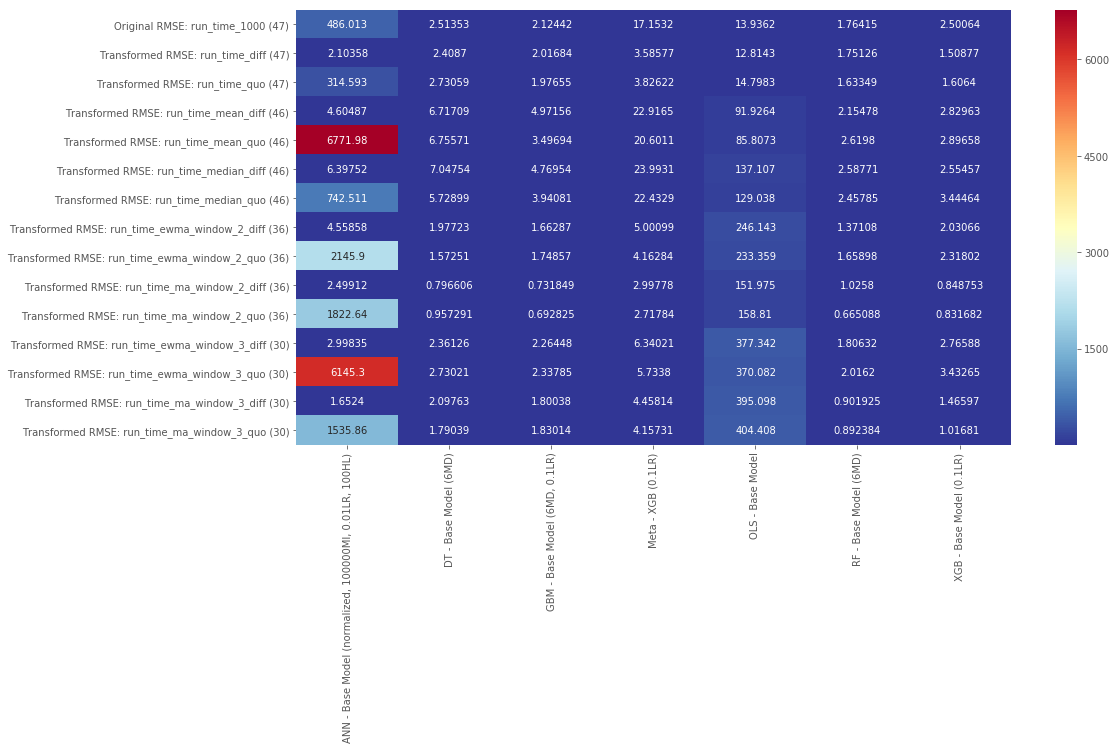

In [13]:
# Set some specs for plotting
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')

value_df = rmse_report.dropna().astype(float).iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap='RdYlBu_r')

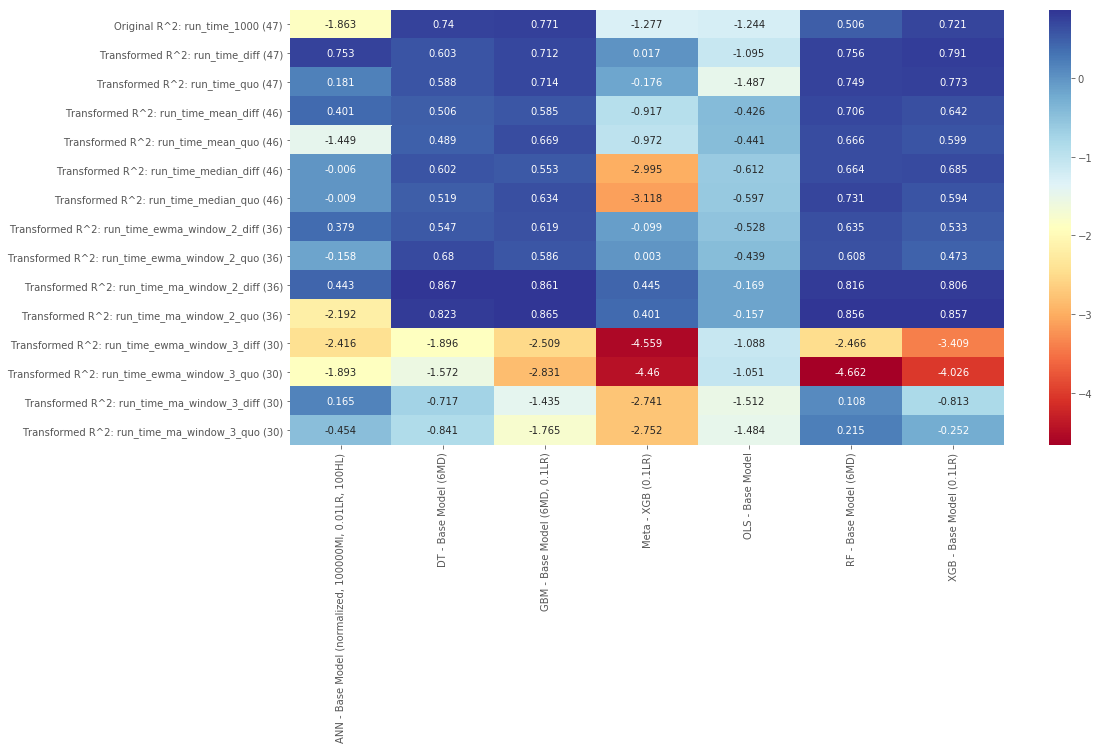

In [14]:
value_df = rsquare_report.dropna().astype(float).iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap='RdYlBu')

In [100]:
def get_best_model(name_saved, model_method, tuned_params):
    # Get the best model from grid search
    try:
        best_df = pd.read_csv(report_directory + '%s_grid_search_report.csv' % name_saved, index_col=0)
    except FileNotFoundError:
        best_df = start_grid_search(model_method=model_method, tuned_params=tuned_params, name_to_save=name_saved)
    return report_best_params(best_df)
        
def report_best_params(df, col_name='best_params'):
    # Get the best reported parameters
    best_dict = {}
    for column in df.columns:
        if type(df[column]['best_params']) is str:
            best_params = eval(df[column]['best_params'])
        else:
            best_params = df[column]['best_params']
        best_params.update({'score': float(df[column]['best_scores'])})
        best_dict[column] = best_params
    return pd.DataFrame(best_dict).T

def start_grid_search(model_method, tuned_params, name_to_save, verbose=2, cv=5, scoring=rmse_score, **params):
    # General method to trigger grid search
    best_dict = {}
    for col_name in mc.y_train.columns:
        grid_search = GridSearchCV(model_method(**params), tuned_params, cv=cv, scoring=scoring, verbose=verbose)
        y = mc.y[col_name].dropna()
        X = mc.X[mc.X.index.isin(y.index)]
        grid_search.fit(X, y)
        best_dict[col_name] = {
            'best_estimator': grid_search.best_estimator_, 
            'best_params': grid_search.best_params_, 
            'best_scores': grid_search.best_score_
        }
    best_df = pd.DataFrame(best_dict)
    file_name = '%s_grid_search_report.csv' % name_to_save
    print('Report file saved as %s' % file_name)
    best_df.to_csv(report_directory + file_name)
    return best_df

## 5.3 Artificial Nerural Network Hyper-parameter Tuning 

In [99]:
ann_tuned_params = [
    {'activation': ['relu', 'tanh'], 
     'learning_rate_init': [0.01, ], 
     'max_iter': [100000, ], 
     'hidden_layer_sizes': [(100, ), (150, ), (200, ), (250, ), (300, ), (350, )]}
]
get_best_model('ann', MLPRegressor, ann_tuned_params)

,activation,hidden_layer_sizes,learning_rate_init,max_iter,score
run_time_1000,tanh,"(150,)",0.01,100000,-9.08307
run_time_diff,tanh,"(100,)",0.01,100000,-1.33557
run_time_ewma_window_2_diff,tanh,"(150,)",0.01,100000,-1.28835
run_time_ewma_window_2_quo,tanh,"(150,)",0.01,100000,-0.051038
run_time_ewma_window_3_diff,tanh,"(100,)",0.01,100000,-1.42618
run_time_ewma_window_3_quo,tanh,"(150,)",0.01,100000,-0.0863002
run_time_ma_window_2_diff,tanh,"(150,)",0.01,100000,-0.978497
run_time_ma_window_2_quo,tanh,"(100,)",0.01,100000,-0.033639
run_time_ma_window_3_diff,tanh,"(150,)",0.01,100000,-0.763785
run_time_ma_window_3_quo,tanh,"(150,)",0.01,100000,-0.0610649


## 5.4 Random Forest Hyper-parameter Tuning

In [ ]:
rf_tuned_params = [
    
]